
#  **K-means Clustering Algorithm (Behind The Scenes)...**
**Building The Algorithm Step by Step (using a real world dataset)**
**vs KMeans Class of Sklearn.cluster**

Summary

> I.   Cleaning & Preprocessing


> II.  The K-Means Algorithm (Behind the Scenes)



> III. Using the Class KMeans & Checking of our built algorithm













## **I: Cleaning & Preprocessing :**

To download the Dataset That willl be used (For building the K-means Algorithm, step by step):  https://www.kaggle.com/lancharro5/seasons-stats-50-19






The definition of columns: see this Glossary:
https://www.basketball-reference.com/about/glossary.html


In [321]:
import pandas as pd
df= pd.read_csv('Seasons_stats_complete.csv')

In [322]:
df.head(3)

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,0.0,0.0,0.368,0.0,0.467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,3.6,3.5,0.0,0.0,0.0,0.0,0.0,144.0,516.0,0.279,0.0,0.0,0.0,144.0,516.0,0.279,0.279,170.0,241.0,0.705,0.0,0.0,0.0,176.0,0.0,0.0,0.0,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,0.0,0.0,0.435,0.0,0.387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6,0.6,2.2,0.0,0.0,0.0,0.0,0.0,102.0,274.0,0.372,0.0,0.0,0.0,102.0,274.0,0.372,0.372,75.0,106.0,0.708,0.0,0.0,0.0,109.0,0.0,0.0,0.0,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,0.0,0.0,0.394,0.0,0.259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,2.8,3.6,0.0,0.0,0.0,0.0,0.0,174.0,499.0,0.349,0.0,0.0,0.0,174.0,499.0,0.349,0.349,90.0,129.0,0.698,0.0,0.0,0.0,140.0,0.0,0.0,0.0,192.0,438.0


In [323]:
#Extract the DataFrame only for NBA point guards
point_guards= df[df['Pos']=='PG']

In [324]:
#compute the points per game (PPG) for each player
pd.options.mode.chained_assignment= None
point_guards['PPG']= point_guards['PTS']/point_guards['G']


In [325]:
#Compute Assistant to Turnover Ratio(A higher AST/TO means more ball control.lower AST/TO means less ball control)
point_guards['AST/TO'] = point_guards['AST']/point_guards['TOV']

In [326]:
#We choose one year (here I choose 2012, we can repeat the same processing for each year form 950 to 2019)
point_guards =point_guards[point_guards['Year']==2013]

In [327]:
#The most performant PG?
a= point_guards[point_guards['AST/TO']>=8]
a

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PPG,AST/TO
21682,21682,2013.0,Josh Akognon,PG,26.0,DAL,3.0,9.0,15.3,0.625,0.5,0.000,0.0,12.1,6.2,19.4,0.0,0.0,0.0,20.3,0.0,0.0,0.0,0.196,4.7,-4.9,-0.2,0.0,2.0,4.0,0.500,1.0,2.0,0.5,1.0,2.0,0.500,0.625,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,5.0,1.666667,inf
21941,21941,2013.0,Charles Jenkins,PG,23.0,PHI,12.0,150.0,8.6,0.377,0.0,0.105,2.2,6.2,4.1,15.7,2.1,0.5,4.8,12.8,0.0,0.1,0.1,0.021,-5.0,-1.0,-5.9,-0.1,14.0,38.0,0.368,0.0,0.0,0.0,14.0,38.0,0.368,0.368,2.0,4.0,0.5,3.0,8.0,11.0,16.0,6.0,1.0,2.0,4.0,30.0,2.500000,8.0


In [328]:
#Because we have only few highly performant PG (it doesn't a cluster, we can consider them as outliers)
#we will drop them from the dataframe (only for reasons for better classification)
point_guards.drop(list(a.index), inplace=True)

In [329]:
point_guards[['PPG','AST/TO']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 21706 to 22239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PPG     106 non-null    float64
 1   AST/TO  104 non-null    float64
dtypes: float64(2)
memory usage: 2.5 KB


In [331]:
#Drop the NaN values
point_guards.dropna(subset=["AST/TO"], how="all",  inplace=True)

In [333]:
point_guards[['PPG','AST/TO']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 21706 to 22239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PPG     104 non-null    float64
 1   AST/TO  104 non-null    float64
dtypes: float64(2)
memory usage: 2.4 KB


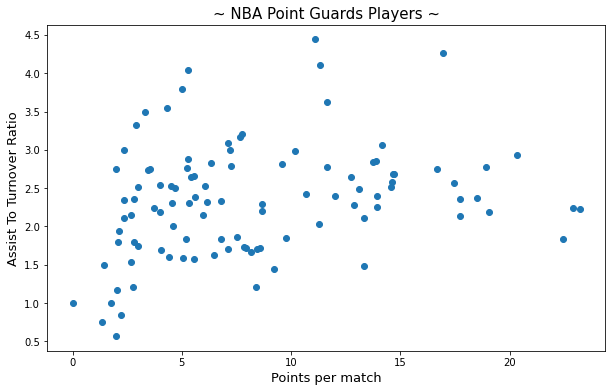

In [334]:
#Visualization
import matplotlib.pyplot as plt
plt.scatter(point_guards['PPG'], point_guards['AST/TO'])
plt.title('~ NBA Point Guards Players ~',fontsize=15)
plt.xlabel('Points per match',fontsize=13)
plt.ylabel('Assist To Turnover Ratio', fontsize=13)
plt.gcf().set_size_inches(10,6)
plt.show()

## **II: The K-Means Algorithm (Behind the Scenes)**


**Step 1: Intitial Centroids (Initial cluster centers)**

Random selection of data points that will be used as intitial centroids

In [335]:
import numpy as np
num_clusters= 5
#use the function random of numpy to generate index list (with the size of num_clusters)
random_initial_points = np.random.choice(point_guards.index, size= num_clusters)

In [336]:
#use the random indexes to create the centroids
centroids= point_guards.loc[random_initial_points]
centroids.head(3)

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PPG,AST/TO
22227,22227,2013.0,Maalik Wayns,PG,21.0,LAC,6.0,37.0,19.5,0.563,0.375,0.25,0.0,6.3,3.2,30.9,4.3,0.0,10.1,24.4,0.1,0.1,0.2,0.227,3.4,-2.5,0.9,0.0,7.0,16.0,0.438,2.0,6.0,0.333,5.0,10.0,0.500,0.500,4.0,4.0,1.000,0.0,2.0,2.0,7.0,3.0,0.0,2.0,8.0,20.0,3.333333,3.500000
22101,22101,2013.0,Ronnie Price,PG,29.0,POR,39.0,510.0,6.8,0.402,0.325,0.20,2.9,7.2,5.0,21.0,2.7,0.4,20.7,14.8,-0.5,0.3,-0.2,-0.017,-4.1,-0.7,-4.8,-0.4,39.0,120.0,0.325,10.0,39.0,0.256,29.0,81.0,0.358,0.367,17.0,24.0,0.708,13.0,31.0,44.0,73.0,26.0,3.0,34.0,61.0,105.0,2.692308,2.147059
21783,21783,2013.0,Mike Conley,PG,25.0,MEM,80.0,2757.0,18.3,0.549,0.312,0.30,1.8,7.9,4.8,29.5,3.4,0.7,15.1,21.0,5.1,4.7,9.9,0.172,3.1,1.1,4.1,4.3,414.0,940.0,0.440,106.0,293.0,0.362,308.0,647.0,0.476,0.497,234.0,282.0,0.830,43.0,182.0,225.0,487.0,174.0,24.0,189.0,171.0,1168.0,14.600000,2.576720


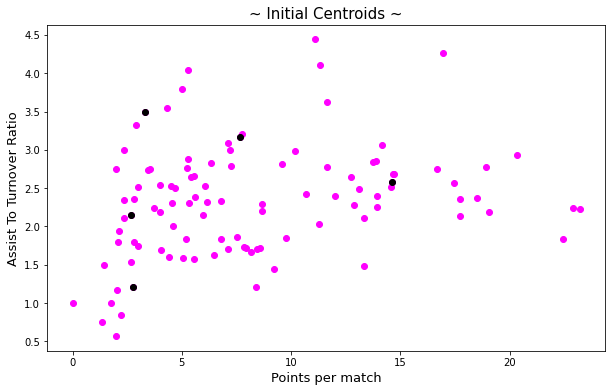

In [338]:
#visualize the initial centroids (chosen randomly)

plt.scatter(point_guards['PPG'], point_guards['AST/TO'], c='magenta')
plt.scatter(centroids['PPG'], centroids['AST/TO'], c='black')
plt.title('~ Initial Centroids ~', fontsize= 15)
plt.xlabel('Points per match', fontsize= 13)
plt.ylabel('Assist To Turnover Ratio', fontsize =13)
plt.gcf().set_size_inches(10,6)
plt.show()


In [339]:
#Create a dictionary of  Intial clusters coordinates

def clusters_dict(df_centroids):
  dict_centroids= dict()
  i= 0
  for j, row in df_centroids.iterrows():
    dict_centroids[i]= [row['PPG'], row['AST/TO']]
    i+=1
  return dict_centroids

dict_coordinates= clusters_dict(centroids)
dict_coordinates

{0: [3.3333333333333335, 3.5],
 1: [2.6923076923076925, 2.1470588235294117],
 2: [14.6, 2.5767195767195767],
 3: [7.65, 3.1717171717171717],
 4: [2.75, 1.206896551724138]}

**Step 2: Assign each data point to the nearest centroid**


In [340]:
# Create a function that computes the distance between one centroid and the players values (here 2D dimensions)
# The points have only 2D coordinates 'PPG' & 'AST/TO', but I will build a genaral function (even for more 2D)
import math 

def compute_distance(cluster_coor, data_point_coordinates):
  distance_2 = 0

  for i in range(0,len(cluster_coor)):
    difference= cluster_coor[i]-data_point_coordinates[i]
    squared_difference = difference ** 2
    distance_2 += squared_difference
    euclid_distance= math.sqrt(distance_2)

  return euclid_distance
#just for checking the function
q=[5,2]
p=[3,1]
compute_distance(q,p)

2.23606797749979

In [341]:
#The idea is that for each instance(data point), we iterate, over the intitial clusters, and we compute
#the distance between each dat point and each centroid (here 5 centroids), we retain the closest centroid
#to each data point
def assign_to_cluster(dict_coor):

  liste=[]
  for i in list(point_guards.index): 
    lowest_distance = -1
    closest_cluster = -1
    for id, centroid in dict_coor.items():
      df_row = [point_guards['PPG'].loc[i], point_guards['AST/TO'].loc[i]]
      distance = compute_distance(centroid, df_row)
      if (lowest_distance == -1) or (distance < lowest_distance) :
        lowest_distance= distance
        closest_cluster = id
      else:
        continue
    liste.append(closest_cluster)
  return liste
point_guards['cluster']= assign_to_cluster(dict_coordinates)


In [342]:
point_guards.iloc[0:5][['Player','PPG','AST/TO','cluster']]

,Player,PPG,AST/TO,cluster
21706,D.J. Augustin,4.684211,2.500000,0
21712,Leandro Barbosa,5.243902,2.761905,0
21713,J.J. Barea,11.270270,2.027586,2
21724,Jerryd Bayless,8.662500,2.200000,3
21729,Rodrigue Beaubois,4.022222,2.545455,0


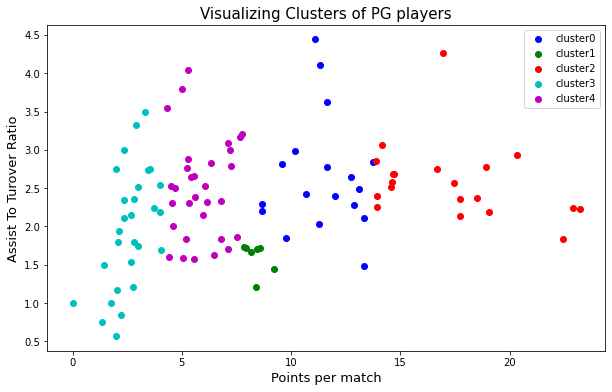

In [277]:
#We can visualize the clusters of the first iteration :
import matplotlib.pyplot as plt
def visualize_clusters(df, num_clusters):
  colors= ['b','g','r','c','m']
  for i in range(num_clusters):
    cluster_df= df[df['cluster']== i]
    plt.scatter (cluster_df['PPG'], cluster_df['AST/TO'], c= colors[i], label='cluster{}'.format(i) )
    plt.xlabel('Points per match', fontsize= 13)
    plt.ylabel('Assist To Turover Ratio', fontsize= 13)
    plt.title('Visualizing Clusters of PG players', fontsize= 15)
    plt.legend(loc='best')
  plt.gcf().set_size_inches(10,6)
  plt.show()
visualize_clusters(point_guards, num_clusters)

**Step 3: Update each cluster center**

Replacing it with the mean of all points assigned to that cluster (in Step 2)

In [343]:
def update_clusters(df):
  new_dict_clusters= dict()
  for i in range(0, num_clusters):
    cluster_df= df[df['cluster']== i]
    new_cluster_coor = [cluster_df['PPG'].mean(), cluster_df['AST/TO'].mean()]
    new_dict_clusters[i]= new_cluster_coor
  return new_dict_clusters
dict_update_clusters= update_clusters(point_guards)
dict_update_clusters

{0: [4.504621655920842, 2.8737061814164684],
 1: [2.8489388891241485, 2.20955426841875],
 2: [15.591178559968169, 2.594887999143585],
 3: [7.745233353102496, 2.2990702557613694],
 4: [2.478360952669029, 1.2043404839094494]}

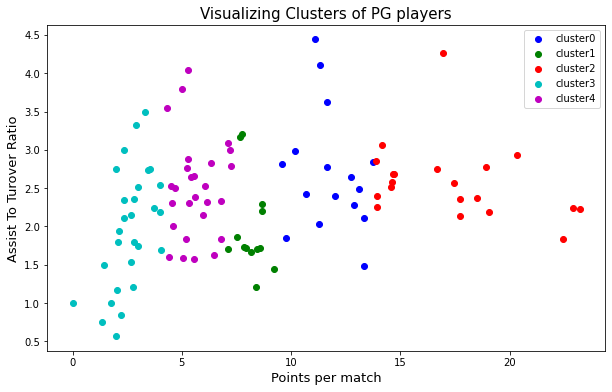

In [279]:
#Repeat Step2
point_guards['cluster'] = assign_to_cluster(dict_update_clusters)
visualize_clusters(point_guards, num_clusters)

**Step 4: Repeat Step 2 & Step 3 (Until convergence):**


In [345]:
for i in range(15):

  dict_update_clusters= update_clusters(point_guards)
  point_guards['cluster'] = assign_to_cluster(dict_update_clusters)
  print(dict_update_clusters)
 


{0: [6.892570640842069, 2.2879037942733653], 1: [3.7033238923451925, 2.4666830053550663], 2: [19.323314857992315, 2.5539555492394737], 3: [12.61582088601426, 2.679502733787803], 4: [1.9023078529657478, 1.3981298175229095]}
{0: [7.2972303578255735, 2.2122058423806714], 1: [4.040463244167718, 2.5636422962205914], 2: [19.323314857992315, 2.5539555492394737], 3: [12.882260001184921, 2.7111869146606895], 4: [1.9940134345836102, 1.4884692652766118]}
{0: [7.656225035277315, 2.19169952810523], 1: [4.524797978996492, 2.5543402669652835], 2: [19.323314857992315, 2.5539555492394737], 3: [12.882260001184921, 2.7111869146606895], 4: [2.1467536853617184, 1.6620492901240005]}
{0: [7.897745147120258, 2.2123370942062417], 1: [4.692981789758297, 2.5400848568434053], 2: [19.323314857992315, 2.5539555492394737], 3: [13.010692135280149, 2.6982997114627136], 4: [2.188374334426966, 1.7043854221090284]}
{0: [8.049606276197308, 2.1794155860240334], 1: [4.866919622506907, 2.514508517971179], 2: [19.323314857992

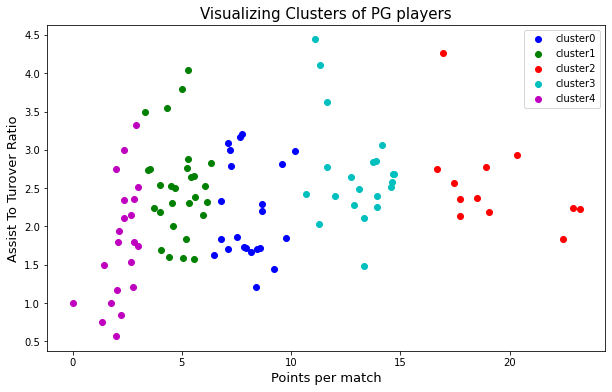

In [346]:
#Visualize the clusters of the last iteration (after convegence)
visualize_clusters(point_guards, num_clusters)

## **III: Using the Class KMeans & Checking of our built algorithm :**
To check The Algorithm that we built !



In [350]:
#we create a new dataframe without the column cluster 
features= list(point_guards.columns)[0:-1]
point_guards_original= point_guards[features]


In [351]:
#we use the KMeans Class of Sklearn
from sklearn.cluster import KMeans
kmeans= KMeans(n_clusters= num_clusters)
kmeans.fit(point_guards_original[['PPG', 'AST/TO']])
point_guards_original['cluster']= kmeans.labels_

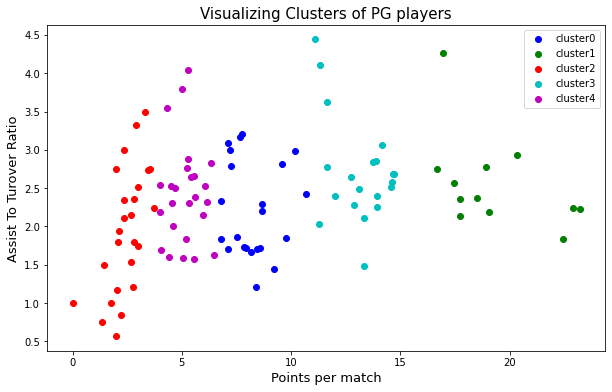

In [352]:
visualize_clusters(point_guards_original, num_clusters)

 **Note:** 

Below , we see The figure with the Algorithm of Kmeans that I have built step by step(the last figure in part II, above): the two figures are very similar: only the color of clusters is different(because it is chosen randomly) but it is the same clasification: the red cluster in my algorithm becomes green (in the KMeans class, the figure above), the purple cluster in my algorithm becomes red, and the green cluster becomes red. 

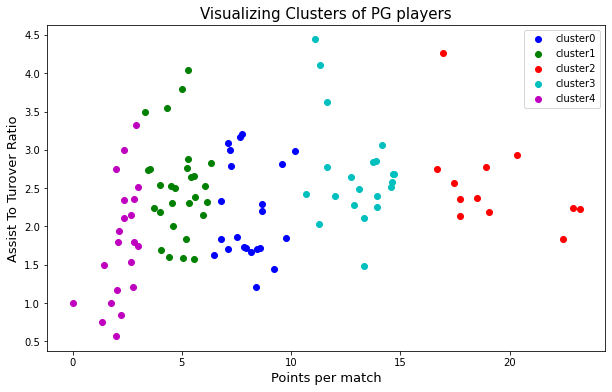

In [353]:
#we can choose the same colors in order to evaluate our Algorithm
point_guards['cluster_adjust']= point_guards['cluster'].map({4:2,1:4,0:0,3:3,2:1})

In [355]:
df= pd.concat([point_guards['cluster_adjust'], point_guards_original['cluster']], axis=1)

In [358]:
df['diff']= df['cluster_adjust']-df['cluster']
df

,cluster_adjust,cluster,diff
21706,4,4,0
21712,4,4,0
21713,3,3,0
21724,0,0,0
21729,4,4,0
...,...,...,...
22226,2,2,0
22227,4,2,2
22230,1,1,0
22235,1,1,0


In [363]:
different_classification = df[df['diff']!=0]
different_classification

,cluster_adjust,cluster,diff
21998,4,2,2
22076,0,4,-4
22102,4,2,2
22127,3,0,3
22191,4,2,2
22227,4,2,2


In [364]:
accuracy= len(different_classification)/len(df)
accuracy

0.057692307692307696